In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

from ML2_lib import loss
from ML2_lib import noise
from ML2_lib import algo_sgd
from ML2_lib import valid


In [5]:
trial_num = 100 #試行回数
result_gauss = [] #パラメータの最終結果　トライアル数*分割数k*特徴量次元
result_loss_gauss = [] # 過剰期待損失の最終結果　トライアル数*分割数k
check_k_num = 50 # 分割数　1 ~ check_k_num
rng = np.random.default_rng()
w_star = np.array([1])
X_mean = 5
X_var = 2
a = 0.01 # 学習率
c = 5 # wの初期値がとりうる範囲
n = 500 # データセットのサンプル数
b = 2.2 # ノイズの分散


for _ in tqdm(range(trial_num)):


    w_per_trial = [] # モデルを貯めていく、必要かどうか
    loss_store = [] # 過剰期待損失を貯めていく
    # ノイズの分散
    # 初期値wの決定
    w = rng.uniform(w_star-c,w_star+c)
    for k in range(1,check_k_num+1):
        core_store = []
        model_store = []
        valid_loss_store = []



        son = loss.LinearQuadraticLoss()
        for _ in range(k):
            # nがデータセットのサンプル数、train_numはその半分
            train_num = n // 2
            # core_num は　k分割した後のサンプル数、
            core_num = train_num  // k
            X = rng.normal(loc=X_mean,size=core_num,scale=X_var)
            E = noise.Gauss(sigma=b,dim=X.shape[0],n=1).generate()
            Y = E + np.dot(w_star,X)
            data = [X,Y]

            core = algo_sgd.SGD(w_init=w,a=a,t_max=core_num-1,data=data)
            for _ in core:
                core.update(son)
            core_store.append(core)
            # :TODO fix axis
            model_store.append(np.mean(core.wstore))


        # ここまでで学習は終了,モデルの候補がk個ある
        # ここからモデルの選択
        valid_num = n // 2
        rng = np.random.default_rng()
        X = rng.normal(loc=X_mean,size=valid_num,scale=X_var)
        E = noise.Gauss(sigma=b,dim=X.shape[0],n=1).generate()
        Y = E + np.dot(w_star,X)
        tmp_loss = []

        # for文を使っているので要修正
        for i in range(k):
            for j in range(k):
                core_num = valid_num // k
                try:
                    tmp_loss.append(son.f(Y[j:j+core_num],X[j:j+core_num],model_store[i]))
                except:
                    raise ValueError()
            valid_loss_store.append(valid.median_of_means(seq=np.array(tmp_loss),n_blocks=3))

        index = np.argmin(valid_loss_store)
        w_rv = model_store[index]
        w_per_trial.append(w_rv)
        # 過剰期待損失　E[(<(w-w^*),X>)^2]　Xが正規分布の場合　E[X^2] = X_mean^2 + X_var^2 * 単位行列
        E_X = np.diag(np.ones(w_star.shape[0])* (X_var**2)  + (X_mean**2))
        excess_risk = np.dot(np.dot(E_X,w_rv),w_rv) + np.dot(np.dot(E_X,w_star),w_star) - 2 * np.dot(np.dot(E_X,w_star),w_rv)
        loss_store.append(excess_risk[0][0])

    result_gauss.append(np.array(w_per_trial))
    result_loss_gauss.append(np.array(loss_store))


result_gauss = np.array(result_gauss)
result_loss_gauss = np.array(result_loss_gauss)






  0%|          | 0/100 [00:00<?, ?it/s]

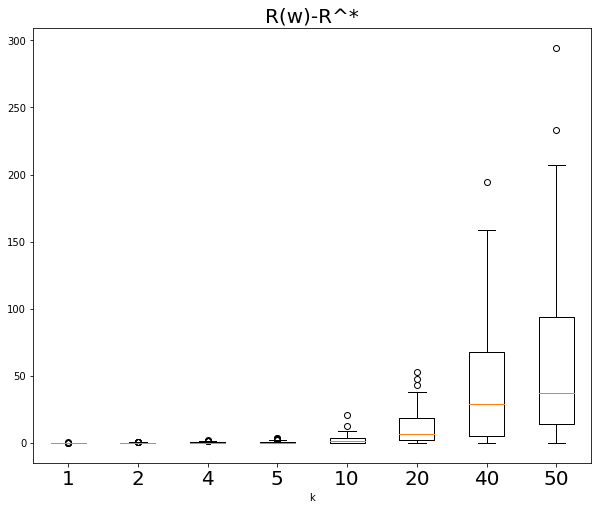

In [6]:
columns=['1', '2', '4','5','10','20','40','50']
fig = plt.figure(figsize=(10.0, 8.0))
ax1 = fig.add_subplot(111)

bp1 = ax1.boxplot(result_loss_gauss[:,[0,1,3,4,9,19,39,49]])
ax1.set_xticklabels(columns,fontsize=20)
ax1.set_title('R(w)-R^*',fontsize=20)
ax1.set_xlabel('k')

plt.show()

In [7]:
df = pd.DataFrame(result_loss_gauss[:,[0,1,3,4,9,19,39,49]],columns=columns)

In [8]:
df.describe()

,1,2,4,5,10,20,40,50
count,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.067128,0.139658,4.562205e-01,0.693915,2.648118,11.444665,40.701274,59.365201
std,0.083298,0.184317,4.850512e-01,0.832224,3.332791,12.525421,41.849355,62.246225
min,0.000155,0.000029,3.960016e-08,0.000184,0.000176,0.005526,0.000012,0.032240
25%,0.007252,0.012231,1.113090e-01,0.054738,0.320520,1.969515,5.021053,13.825434
50%,0.039786,0.074784,2.880707e-01,0.371614,1.451187,6.743761,29.120502,37.115622
75%,0.095403,0.190145,6.494165e-01,1.036890,3.915420,18.306729,67.966495,94.137730
max,0.469190,1.020588,2.468202e+00,3.601953,21.184294,53.219982,194.630916,294.505695


In [10]:
# lognormal

trial_num = 100 #試行回数
result_log_normal = [] #パラメータの最終結果　トライアル数*分割数k*特徴量次元
result_loss_log_normal = [] # 過剰期待損失の最終結果　トライアル数*分割数k
check_k_num = 50 # 分割数　1 ~ check_k_num
rng = np.random.default_rng()
w_star = np.array([1])
X_mean = 5
X_var = 2
a = 0.01 # 学習率
c = 5 # wの初期値がとりうる範囲
n = 500 # データセットのサンプル数
b = 1.75 # ノイズの分散

for _ in tqdm(range(trial_num)):


    w_per_trial = [] # モデルを貯めていく、必要かどうか
    loss_store = [] # 過剰期待損失を貯めていく
    # 初期値wの決定
    w = rng.uniform(w_star-c,w_star+c)
    for k in range(1,check_k_num+1):
        core_store = []
        model_store = []
        valid_loss_store = []



        son = loss.LinearQuadraticLoss()
        for _ in range(k):
            # nがデータセットのサンプル数、train_numはその半分
            train_num = n // 2
            # core_num は　k分割した後のサンプル数、
            core_num = train_num  // k
            X = rng.normal(loc=X_mean,size=core_num,scale=X_var)
            E = noise.Gauss(sigma=b,dim=X.shape[0],n=1).generate()
            Y = E + np.dot(w_star,X)
            data = [X,Y]

            core = algo_sgd.SGD(w_init=w,a=a,t_max=core_num-1,data=data)
            for _ in core:
                core.update(son)
            core_store.append(core)
            # 平均のaxis　要修正
            model_store.append(np.mean(core.wstore))


        # ここまでで学習は終了,モデルの候補がk個ある
        # ここからモデルの選択
        valid_num = n // 2
        rng = np.random.default_rng()
        X = rng.normal(loc=X_mean,size=valid_num,scale=X_var)
        E = noise.Gauss(sigma=b,dim=X.shape[0],n=1).generate()
        Y = E + np.dot(w_star,X)
        tmp_loss = []
        # for文を使っているので要修正
        for i in range(k):
            for j in range(k):
                core_num = valid_num // k
                tmp_loss.append(son.f(Y[j:j+core_num],X[j:j+core_num],model_store[i]))
            valid_loss_store.append(valid.median_of_means(seq=np.array(tmp_loss),n_blocks=3))

        index = np.argmin(valid_loss_store)
        w_rv = model_store[index]
        w_per_trial.append(w_rv)
        # 過剰期待損失　E[(<(w-w^*),X>)^2]　Xが正規分布の場合　E[X^2] = X_mean^2 + X_var^2 * 単位行列
        E_X = np.diag(np.ones(w_star.shape[0])* (X_var**2)  + (X_mean**2))
        excess_risk = np.dot(np.dot(E_X,w_rv),w_rv) + np.dot(np.dot(E_X,w_star),w_star) - 2 * np.dot(np.dot(E_X,w_star),w_rv)
        loss_store.append(excess_risk[0][0])

    result_log_normal.append(np.array(w_per_trial))
    result_loss_log_normal.append(np.array(loss_store))


result_log_normal = np.array(result_log_normal)
result_loss_log_normal = np.array(result_loss_log_normal)



  0%|          | 0/100 [00:00<?, ?it/s]

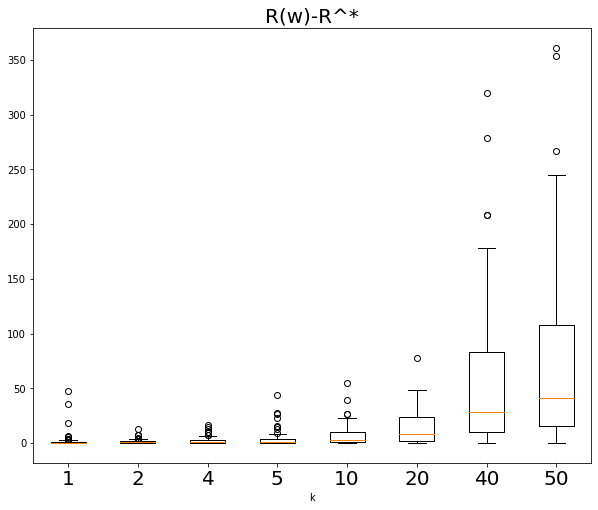

In [11]:
columns=['1', '2', '4','5','10','20','40','50']
fig = plt.figure(figsize=(10.0, 8.0))
ax1 = fig.add_subplot(111)

bp1 = ax1.boxplot(result_loss_log_normal[:,[0,1,3,4,9,19,39,49]])
ax1.set_xticklabels(columns,fontsize=20)
ax1.set_title('R(w)-R^*',fontsize=20)
ax1.set_xlabel('k')

plt.show()

In [12]:
df = pd.DataFrame(result_loss_log_normal[:,[0,1,3,4,9,19,39,49]],columns=columns)

df.describe()

,1,2,4,5,10,20,40,50
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.843082,1.242918,2.233530,3.536950,6.402201,14.538264,55.875754,72.906149
std,6.072137,1.899758,3.111277,6.448107,8.478546,15.147228,64.008517,77.494874
min,0.000062,0.000562,0.002064,0.000107,0.000005,0.001529,0.004020,0.031885
25%,0.152150,0.153631,0.253930,0.306038,0.556737,2.053379,10.179020,15.900117
50%,0.474256,0.706164,0.858568,1.373626,3.205427,8.583786,28.695388,40.859026
75%,1.098690,1.507700,3.001009,3.740960,9.677875,23.587065,83.376567,108.111629
max,47.111045,13.061436,16.307706,43.598844,54.674518,78.081946,319.906456,361.259842
